In [1]:
import random
import torch
from d2l import torch as d2l

In [2]:
tokens = d2l.tokenize(d2l.read_time_machine())
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)

print(vocab.token_freqs[:10])

[('the', 2261), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816), ('to', 695), ('was', 552), ('in', 541), ('that', 443), ('my', 440)]


画出词频图</br>
停用词：是在文本处理中经常要忽略的词汇，因为它们通常不对文本的意义产生重要贡献。</br>
      常见的停用词包括代词、介词、连词、冠词等。另外，在英文中还有一些高频词如 "the" "and" "a" 等被认为是停用词。

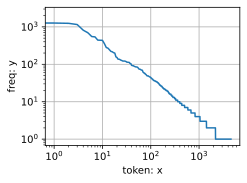

In [3]:
freq = [freq for token, freq in vocab.token_freqs]
d2l.plot(freq, xlabel='token: x', ylabel='freq: y', xscale='log', yscale='log')

二元语法和三元语法的词频，即数据集中两个词元为一组的组合和三个词元为一组的组合的出现频率。

In [4]:
bi_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bi_vocab = d2l.Vocab(bi_tokens)
bi_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [5]:
tri_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
tri_vocab = d2l.Vocab(tri_tokens)
tri_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

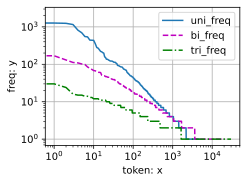

In [6]:
bi_freq = [freq for token, freq in bi_vocab.token_freqs]
tri_freq = [freq for token, freq in tri_vocab.token_freqs]
d2l.plot([freq, bi_freq, tri_freq], xlabel='token: x', ylabel='freq: y', xscale='log', yscale='log', legend=['uni_freq','bi_freq','tri_freq'])

随机生成一个小批量数据以供读取特征和标签。</br>
在随机采样中，每个样本都是从原始长序列上任意捕获的子序列。</br>
对于语言建模，目标是基于到目前为止我们看到的词元来预测下一个词元， 因此标签是移位了一个词元的原始序列。</br>

In [10]:
def seq_data_iter_random(corpus, batch_size, num_steps): #num_steps为随即偏移量
    # 依据随即偏移量，对数据集进行顺序分区
    corpus = corpus[random.randint(0, num_steps-1):] 
    # 计算子序列的数量
    num_subseqs = (len(corpus)-1) // num_steps
    # 建立长度为num_steps的子序列的起始索引
    indices = list(range(0, num_subseqs * num_steps, num_steps))
    random.shuffle(indices)
    
    def data(pos):
        # 返回指定区间长度的序列
        return corpus[pos: pos + num_steps]
    
    num_batches = num_subseqs // batch_size
    for i in range(0, num_batches * batch_size, batch_size): 
        #每个batch的起始位置
        iter_indices_per_batch = indices[i: i + batch_size]
        X = [data(j) for j in iter_indices_per_batch]
        Y = [data(j + 1) for j in iter_indices_per_batch]
        # 保留一次迭代的特征和标签
        yield torch.tensor(X), torch.tensor(Y)

生成一个长度为34的的长序列。设置步长为5，batch_size为2，这样能得到（35-1）//6=5个子序列对。

In [11]:
seq = list(range(34))
for X, Y in seq_data_iter_random(seq, 2, 5):
    print("X:",X, "\nY:", Y)

X: tensor([[ 7,  8,  9, 10, 11],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 8,  9, 10, 11, 12],
        [18, 19, 20, 21, 22]])
X: tensor([[27, 28, 29, 30, 31],
        [ 2,  3,  4,  5,  6]]) 
Y: tensor([[28, 29, 30, 31, 32],
        [ 3,  4,  5,  6,  7]])
X: tensor([[22, 23, 24, 25, 26],
        [12, 13, 14, 15, 16]]) 
Y: tensor([[23, 24, 25, 26, 27],
        [13, 14, 15, 16, 17]])


In [23]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_batches * num_steps, num_steps):
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X, Y

In [24]:
for X, Y in seq_data_iter_sequential(seq, 2, 5):
    print("X:",X, "\nY:", Y)

X: tensor([[ 1,  2,  3,  4,  5],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]])
X: tensor([[ 6,  7,  8,  9, 10],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]])
X: tensor([[11, 12, 13, 14, 15],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]])


In [25]:
class SeqDataLoader:
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [26]:
def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.Vocab